# **To Restart Notebook**

In [ ]:
import os

os.kill(os.getpid(), 9)

# **Import Required Libraries** ⭕

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.metrics import SparseCategoricalAccuracy,CategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.datasets import mnist
from PIL import Image
import math

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Load MNIST Data**

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# **Visualize Sample** 👀

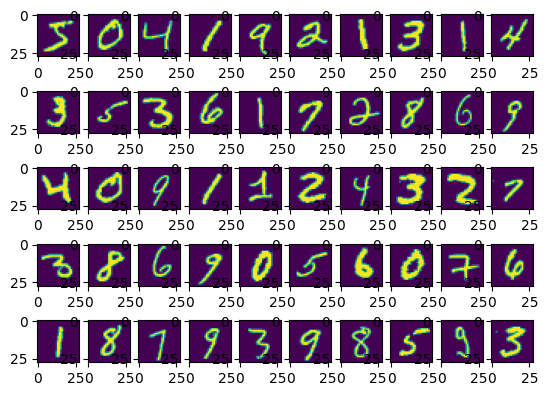

In [3]:
fig, axs = plt.subplots(5, 10)
cnt = 0
for i in range(5):
     for j in range(10):
         axs[i, j].imshow(X_train[cnt])
         cnt += 1

In [4]:
print('The shape of the training inputs:', X_train.shape)
print('The shape of the training labels:',y_train.shape)
print('The shape of the testing inputs:',X_test.shape)
print('The shape of the testing labels:',y_test.shape)

The shape of the training inputs: (60000, 28, 28)
The shape of the training labels: (60000,)
The shape of the testing inputs: (10000, 28, 28)
The shape of the testing labels: (10000,)


# **Apply Normalization**

In [5]:
# Normalize the images.
X_train = (X_train / 255) - 0.5
X_test = (X_test / 255) - 0.5

# **Data Augmentation** ➕

In [6]:
# Reshape the data to add a channel dimension (for compatibility with ImageDataGenerator)
X_train = np.expand_dims(X_train, axis=-1)

# Create a mask for selecting 3/4 of the data
mask = np.random.choice([False, True], size=len(X_train), p=[1/20, 19/20])

# Create an ImageDataGenerator instance with the desired augmentation options
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.005,
    zoom_range=0.05,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the selected subset of training data
datagen.fit(X_train[mask])

# Generate augmented images in batches and add them to the original data
augmented_images = datagen.flow(X_train[mask], y_train[mask], batch_size=len(X_train[mask]), shuffle=False)

# Extract augmented images and labels from the generator
x_augmented, y_augmented = augmented_images.next()

# Concatenate original and augmented data
x_train_augmented = np.concatenate((X_train, x_augmented))
y_train_augmented = np.concatenate((y_train, y_augmented))
print("Shape of augmented training set:", x_train_augmented.shape, y_train_augmented.shape)

Shape of augmented training set: (117010, 28, 28, 1) (117010,)


In [7]:
# Function to shift an image by one pixel in a given direction
def shift_image(image, direction):
    shifted_image = np.roll(image, shift=direction, axis=(0, 1))
    return shifted_image

# Create shifted copies of each image in the training set
directions = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Left, right, up, down
x_train_shifted = []
y_train_shifted = []
for image, label in zip(X_train, y_train):
    for direction in directions:
        shifted_image = shift_image(image, direction)
        x_train_shifted.append(shifted_image)
        y_train_shifted.append(label)

# Convert the lists to numpy arrays
x_train_shifted = np.array(x_train_shifted)
y_train_shifted = np.array(y_train_shifted)

# Add the shifted copies to the original training set
x_train_augmented = np.concatenate((x_train_augmented, x_train_shifted))
y_train_augmented = np.concatenate((y_train_augmented, y_train_shifted))
# Add the shifted copies to the original training set
x_train_augmented = np.concatenate((x_train_augmented, X_train))
y_train_augmented = np.concatenate((y_train_augmented, y_train))

# Shuffle the augmented training set
shuffle_indices = np.random.permutation(len(x_train_augmented))
X_train = x_train_augmented[shuffle_indices]
y_train = y_train_augmented[shuffle_indices]

# Display the shape of the augmented training set
print("Shape of augmented training set:", X_train.shape, y_train.shape)

Shape of augmented training set: (417010, 28, 28, 1) (417010,)


In [8]:
# Reshape the images.
#X_train = X_train.reshape((-1, 28 * 28))
#X_test = X_test.reshape((-1, 28 * 28))

In [9]:
X_train = x_train_augmented
y_train = y_train_augmented
# Reshape the images.
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

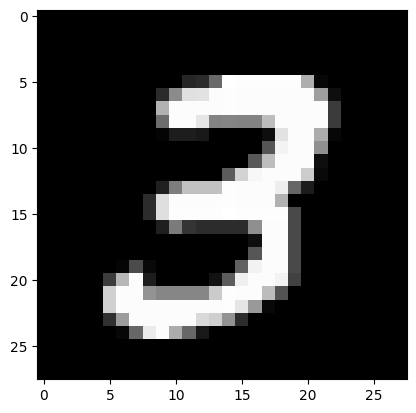

In [10]:
plt.imshow(X_train[7][:,:,0],cmap='gray')#,cmap='grayscale' google greyscale in matplot
plt.show()

In [11]:
y_train[7]

3

# **Bulid the Model**

In [12]:
n_epochs = 100
initializer = RandomNormal(mean=0., stddev=1.)

In [13]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
  Flatten(input_shape=(28, 28)),
  Dense(512, activation='relu', kernel_initializer=initializer, input_shape=(28 * 28,)),
  BatchNormalization(),
  Dense(256, activation='relu', kernel_initializer=initializer),
  BatchNormalization(),
  Dense(128, activation='relu', kernel_initializer=initializer),
  BatchNormalization(),
  Dense(64, activation='relu', kernel_initializer=initializer),
  BatchNormalization(),
  Dense(10, activation='softmax', kernel_initializer=initializer)
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               3

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


# **Train The Model**

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=20,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

model.compile(
    optimizer='adam',
    loss= CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()],
)

history = model.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,
    validation_data=(X_test, to_categorical(y_test)),
    callbacks=[early_stopping]  # Pass the EarlyStopping callback to the fit method
)

Epoch 1/100
13032/13032 [==============================] - 80s 6ms/step - loss: 0.4506 - categorical_accuracy: 0.8935 - val_loss: 0.0791 - val_categorical_accuracy: 0.9745
Epoch 2/100
13032/13032 [==============================] - 77s 6ms/step - loss: 0.1100 - categorical_accuracy: 0.9653 - val_loss: 0.0611 - val_categorical_accuracy: 0.9814
Epoch 3/100
13032/13032 [==============================] - 78s 6ms/step - loss: 0.0776 - categorical_accuracy: 0.9752 - val_loss: 0.0595 - val_categorical_accuracy: 0.9823
Epoch 4/100
13032/13032 [==============================] - 80s 6ms/step - loss: 0.0624 - categorical_accuracy: 0.9799 - val_loss: 0.0550 - val_categorical_accuracy: 0.9835
Epoch 5/100
13032/13032 [==============================] - 79s 6ms/step - loss: 0.0527 - categorical_accuracy: 0.9830 - val_loss: 0.0439 - val_categorical_accuracy: 0.9864
Epoch 6/100
13032/13032 [==============================] - 78s 6ms/step - loss: 0.0462 - categorical_accuracy: 0.9847 - val_loss: 0.0472 - v

# **Visulaize The Loss and Accuracy Over Epochs** 👁

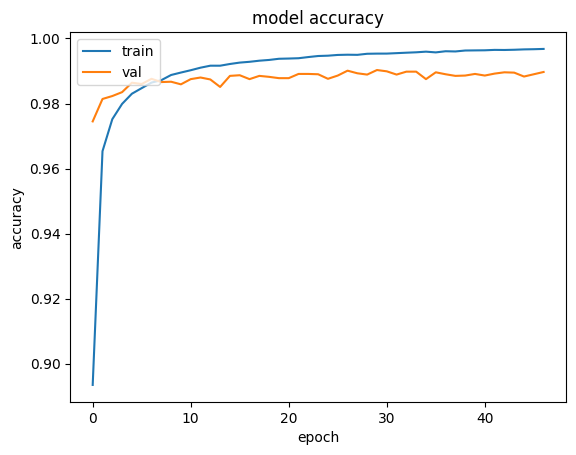

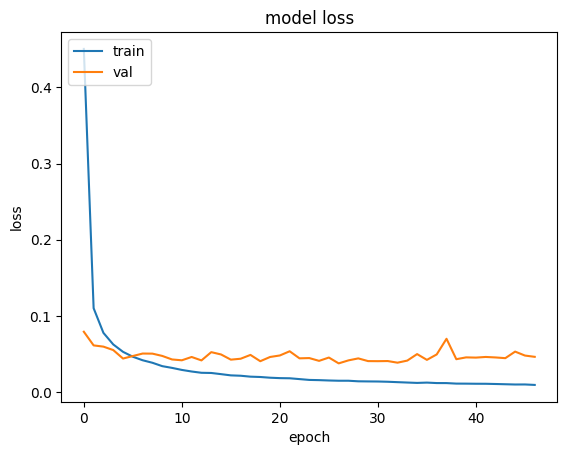

In [15]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **GOT 99.01% ACCURACY!!! ✌**

In [16]:
_, accuracy = model.evaluate(X_test, to_categorical(y_test))
print('Accuracy: %.2f' % (accuracy * 100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0375 - categorical_accuracy: 0.9901
Accuracy: 99.01


# **Predict Sample**

In [17]:
predictions = model.predict(X_test[:5])
print(predictions.shape)
print(predictions)


# Print our model's predictions.
print("Predictions")
print(np.argmax(predictions, axis=1)) # [7, 2, 1, 0, 4]

print("Data")
# Check our predictions
print(y_test[:5]) # [7, 2, 1, 0, 4]


1/1 [==============================] - 0s 125ms/step
(5, 10)
[[2.6416762e-13 1.9002306e-08 2.5059252e-10 4.0101837e-09 1.9669055e-09
  5.5320298e-10 8.8908930e-16 1.0000000e+00 1.7243398e-10 1.5783991e-08]
 [2.5369137e-14 3.3868581e-09 9.9999952e-01 6.1996692e-09 2.6794572e-15
  7.9331697e-10 7.4166159e-11 4.5442352e-09 5.0798519e-07 8.2125253e-12]
 [2.2137697e-15 1.0000000e+00 5.9416354e-11 8.0529238e-14 3.3099290e-10
  1.6492680e-12 1.6355228e-11 1.3022936e-09 1.7613855e-12 7.3528759e-13]
 [9.9998426e-01 3.9808564e-13 4.3009801e-11 5.8726232e-11 2.8242246e-12
  1.2564661e-08 1.5735313e-05 1.2640932e-12 2.7445141e-13 2.5692479e-10]
 [1.2254816e-17 9.6912780e-09 1.8602102e-11 2.0983874e-11 9.9999630e-01
  1.9209306e-14 1.0286847e-10 6.3108909e-09 1.8399512e-12 3.7158227e-06]]
Predictions
[7 2 1 0 4]
Data
[7 2 1 0 4]


In [18]:
# Function to display images with their predicted labels
def display_images(images, labels_true, labels_pred, rows=5):
    cols = math.ceil(len(images) / rows)
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"True: {labels_true[i]}, Pred: {labels_pred[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 16ms/step


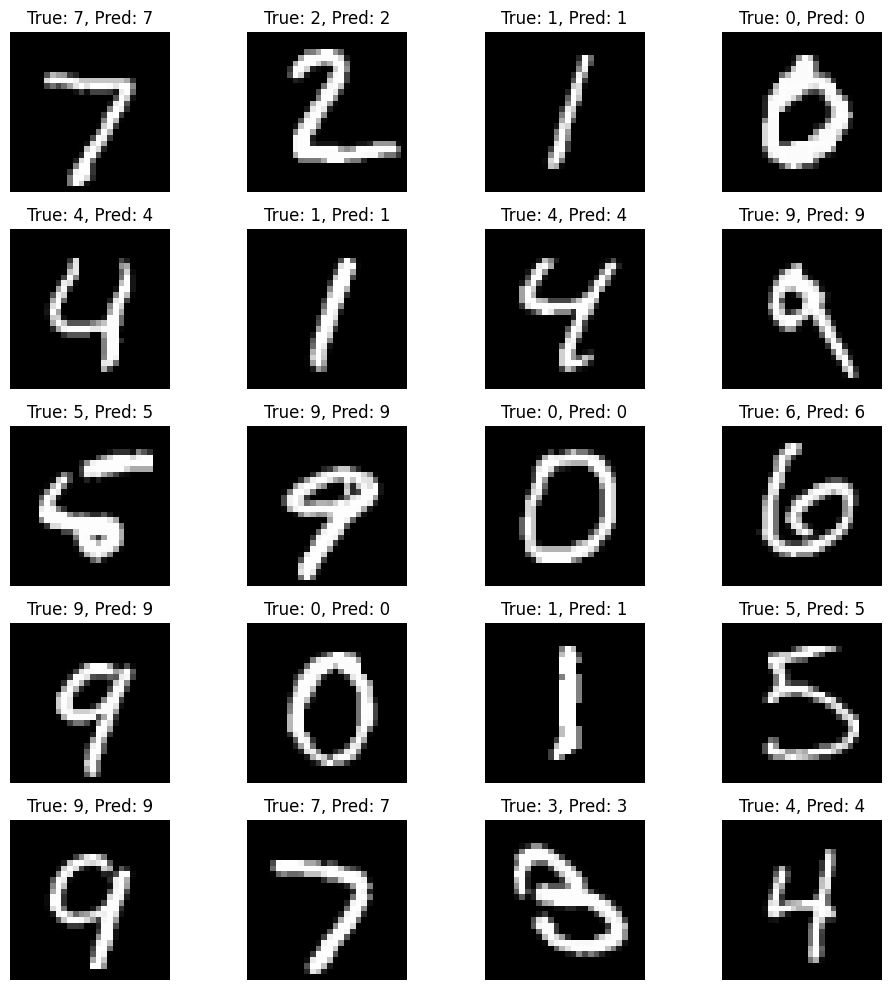

In [19]:
# Make predictions on the first 20 test images
predictions = model.predict(X_test[:20])

# Display the images along with their predicted labels in 5 rows
display_images(X_test[:20, :, :, 0], y_test[:20], np.argmax(predictions, axis=1), rows=5)

# **Save My Model** ❌

In [20]:
# Save the model to a file
model.save("MNIST_Model_99.01%_BY_SAAD.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Try My Model For Free By Uploading you test images 🈺**

Saving img_125.jpg to img_125.jpg
1/1 [==============================] - 0s 118ms/step


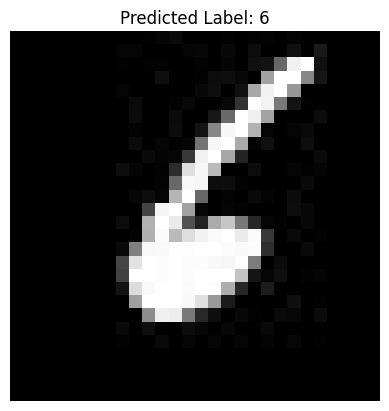

In [25]:
from google.colab import files
from io import BytesIO
from PIL import Image as PILImage
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Upload an image file
uploaded = files.upload()

# Load the saved model
model = load_model("MNIST_Model_99.01%_BY_SAAD.h5")

# Read the uploaded image file
for filename in uploaded.keys():
    image_bytes = uploaded[filename]
    img = PILImage.open(BytesIO(image_bytes))

# Preprocess the image
img = np.array(img)
img = img.reshape(1, 28, 28, 1)
img = img.astype('float32')
img = (img / 255) - 0.5

# Make predictions
predictions = model.predict(img)
predicted_label = np.argmax(predictions)

# Display the image and the predicted label
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()